<a href="https://colab.research.google.com/github/snvssk/data298A/blob/saidev/U_Net_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.4 MB/s 


#Importing Libraries

In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify # divide images to patches
from PIL import Image # Pillow used for operations like  cropping/resizing of images 
import segmentation_models as sm # To use the pre-trained U-net like VGG with some imagenet weights 
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


Segmentation Models: using `keras` framework.


#Patching step on Images Directory

In [ ]:
root_directory = '/content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/'

patch_size = 256 # Defining patch size

#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Look for 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory by making images = directory path 
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as RGB by using cv2
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)     # Converting it to numpy array         
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255 to scale images. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img) #Adding it to image dataset list 
                
  

Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_008.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_005.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_003.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_009.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_006.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_007.jpg
Now patchifying image: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/images/image_part_002.jpg
Now patchifying 

#Applying same step on Masks - Difference is of PNG type and BGR 

In [ ]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
import os
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB) 
# IN OPENCV WHEN U READ IMAGES IN COLOR THEY ARE READ AS BGR, and we have convetred BGR to RGB
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)



Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_003.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_007.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_009.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_006.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_005.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_001.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_004.png
Now patchifying mask: /content/drive/Shareddrives/DATA298A/Semantic segmentation dataset/Tile 6/masks/image_part_008.png
Now patchifying mask: /content/d

#Sanity check, view few images to makesure images and masks are matching

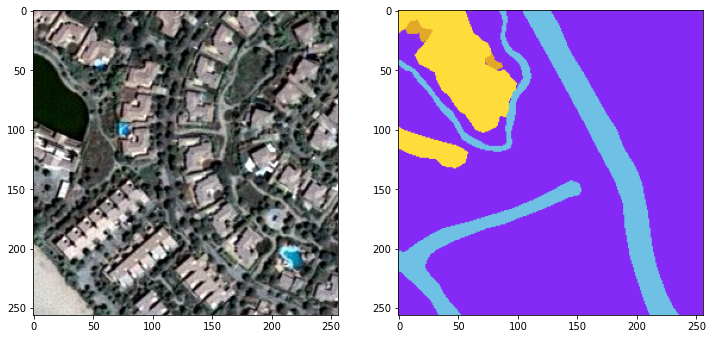

In [ ]:

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

#HEX to RGB 

In [ ]:

#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask



60


#Converting RGB labels to 2D label

Unique labels in label dataset are:  [0 1 2 3 4 5]


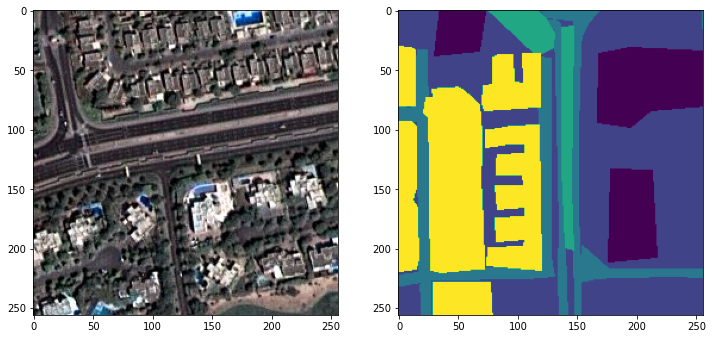

In [ ]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()




#Applying One Hot Encoding

In [ ]:
n_classes = len(np.unique(labels))
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)



#Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [ ]:
!python simple_multi_unet_model.py install

In [ ]:
# Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666] # 1/6= 0.1666 , 6 here are the number of classes 
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('models/satellite_standard_unet_100epochs.hdf5')




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

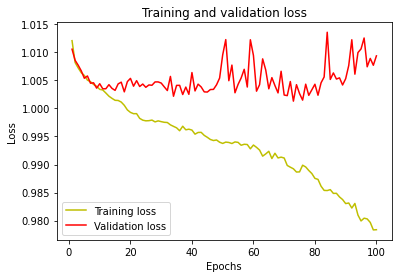

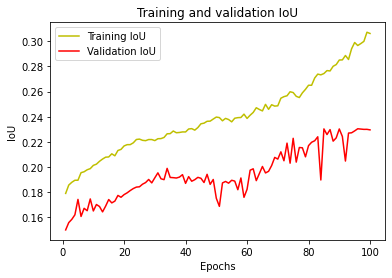

In [ ]:

#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


Mean IoU = 0.154105


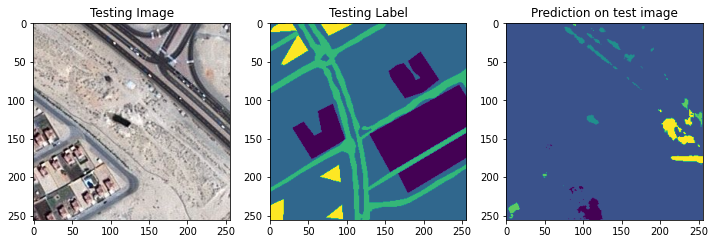

In [ ]:

from keras.models import load_model
#model = load_model("models/satellite_standard_unet_100epochs.hdf5", custom_objects={'dice_loss_plus_2focal_loss': total_loss,'jacard_coef':jacard_coef})

model = load_model("models/satellite_standard_unet_100epochs.hdf5", compile=False)

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

Reference - https://www.youtube.com/watch?v=jvZm8REF2KY&list=LL&index=5&ab_channel=DigitalSreeni